# Mortality Data Analysis

### Preprocessing

In [3]:
def education_calc(row):
    flag = row['education_reporting_flag']
    rev_89 = row['education_1989_revision']
    rev_03 = row['education_2003_revision']
    
    # 1989 recode
    if flag == 0:
        # If not stated
        if rev_89 == 99:
            return 0
        # If primary school or less
        elif rev_89 >= 0 and rev_89 <= 8:
            return 1
        # If some amount of secondary school
        elif rev_89 >= 9 and rev_89 <= 12:
            return 2
        # Complete or currently working on associate's or bachelor's degree
        elif rev_89 >= 13 and rev_89 <= 16:
            return 3
        # >4 years of school
        else:
            return 4
    # 2003 recode
    elif flag == 1:
        # "unknown"
        if rev_03 == 9:
            return 0
        # primary school
        elif rev_03 == 1:
            return 1
        # Some amount of secondary school
        elif rev_03 == 2 or rev_03 == 3:
            return 2
        # College up to bachelors
        elif rev_03 == 4 or rev_03 == 5 or rev_03 == 6:
            return 3
        # >4 years
        else:
            return 4
    # Nothing reported
    else:
        return 0

In [72]:
## Here we concatinate all csv's into one single one.
#File loading method stack overflow link: https://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe
#All dataframe methods learned from pandas documentation
#np.where learned from numpy documentation

import numpy as np
import pandas as pd
import glob
import os
import pickle
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score
from sklearn import preprocessing
import matplotlib.pyplot as plt


filename = 'MortalityCondensed.csv'
pd.set_option('display.max_columns',500)
pd.options.mode.chained_assignment = None 

def process_files(local_path):
    #Load all .csv files in the mortality directory
    all_files = glob.glob(local_path + "/*.csv")
    dataframe = pd.DataFrame()
    file_list = []

    for file in all_files:
        df = pd.read_csv(file, index_col = None, header = 0, low_memory = False)

        dfInterest = df[['sex','race','detail_age','month_of_death', 'manner_of_death', 'education_reporting_flag','education_2003_revision','education_1989_revision','hispanic_origin']] #Isolate columns we need
        dfInterest['binary_male'] = np.where(dfInterest['sex']=='M', 1, 0)
        dfInterest['manner_of_death_cleaned'] = np.where(np.isnan(dfInterest['manner_of_death']), 0, dfInterest['manner_of_death'])
        #dfInterest['binary_suicide'] = np.where(dfInterest['manner_of_death']==2, 1, 0) #create the binary suicide column

        #Recode education to get rid of NaNs. Code 18 represents where we have no data.
        dfInterest['education'] = dfInterest.apply(education_calc, axis=1)
        print(dfInterest['education'].head())

        #Recode race to give us more meaningful categories 0 hispanic, 1 white, 2 black, 3 asian
        dfInterest['binary_white'] = np.where(dfInterest['race'] == 1, 1, 0)
        dfInterest['binary_black'] = np.where(dfInterest['race'] == 2, 1, 0)
        dfInterest['binary_asian'] = np.where(dfInterest['race'] > 2, 1, 0)
        dfInterest['binary_hispanic'] = np.where(dfInterest['hispanic_origin'] > 199, 1, 0)        
        file_list.append(dfInterest) #add the new dataframe to the list
    
    dataframe = pd.concat(file_list) #concat the whole list to the final dataframe
    finaldf = dataframe.drop(columns=['race', 'sex', 'education_reporting_flag','education_2003_revision','education_1989_revision'])

    # Reordering
    finaldf = finaldf[['binary_male', 'binary_white', 'binary_black', 'binary_asian', 'binary_hispanic',
                      'detail_age', 'month_of_death', 'education','manner_of_death_cleaned']]
    finaldf.to_csv(filename)
    finaldf.head()
    print(finaldf.isnull().sum())#showing number of null values, shoulw be 0 after recode


## Building Test and Train sets

In [77]:
# Check if base_file exists
# If not, create it
if not os.path.isfile(filename):
    process_files("mortality")
df = pd.read_csv(filename, header=0, encoding='ISO-8859-1', engine='python')
#new_df = df.sample(int(len(df)/4))
#print(new_df.head())
# Split into training and test
# https://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas
df = df[df.manner_of_death_cleaned != 0]
print(df['manner_of_death_cleaned'].value_counts())

msk = np.random.rand(len(df)) < 0.9
train = df[msk]
test = df[~msk]


# 1:Accident
# 2:Suicide
# 3:Homicide
# 4:Pending investigation
# 5:Could not determine
# 6:Self-Inflicted
# 7:Natural

Y_train = np.where(train.iloc[:,len(train.columns)-1] == 2, 1, 0)
X_train = train.iloc[:,1:(len(train.columns)-1)]
Y_test = np.where(test.iloc[:,len(test.columns)-1] == 2, 1, 0)
X_test = test.iloc[:,1:(len(test.columns)-1)]

#Y_train = train.iloc[:,len(train.columns)-1]
#Y_test = test.iloc[:,len(test.columns)-1]

7.0    19914162
1.0     1350268
2.0      423361
3.0      200528
5.0      119756
4.0       55808
Name: manner_of_death_cleaned, dtype: int64


In [13]:
X_train

,binary_male,binary_white,binary_black,binary_asian,binary_hispanic,detail_age,month_of_death,education
0,0,1,0,0,0,45,1,2
1,1,1,0,0,0,61,1,3
2,0,1,0,0,0,79,1,2
3,1,1,0,0,0,50,1,2
4,0,1,0,0,0,68,1,3
5,0,0,0,1,0,89,1,1
6,0,1,0,0,0,68,1,2
7,1,0,0,1,0,61,1,2
8,0,1,0,0,0,73,1,3
9,0,1,0,0,0,85,1,1


## Predicting Suicide vs Non-Suicide

### Logistic Regression

In [74]:
%%time
#sources http://scikit-learn.org/stable/modules/sgd.html
#running gridsearchCV on a generic SGCclassifier to seek out optmized meta-paramaters
#########GRIDSEARCH##########################
from sklearn import grid_search
param_grid = {
    'loss': ['log'],
    'penalty': ['elasticnet'],
    'alpha': [10 ** x for x in range(-6, 1)],
    'l1_ratio': [0, 0.05, 0.1, 0.2, 0.4, 0.8, 0.9, 0.95, 1],
    'epsilon':[10.0**-np.arange(1,7)]
}

SGC_generic = SGDClassifier(random_state=0, class_weight='balanced')

SGC_generic_gridsearch = grid_search.GridSearchCV(estimator=SGC_generic, param_grid=param_grid,
                                    n_jobs=-1, scoring='roc_auc', cv= 5)

SGC_generic_gridsearch.fit(X=X_train, y=Y_train)
print ("The best estimators are: ")
print (SGC_generic_gridsearch.best_estimator_)
#########GRIDSEARCH##########################

alpha_arr = [0.0001,0.001,0.01,0.1,1.0,10.0,100.0]
#alpha_arr = [0.01]
train_acc = []
test_acc = []
for a in alpha_arr:    
    classifier = SGDClassifier(loss='log', max_iter=200, tol=1.0e-9, random_state=123, alpha=a)
    classifier.fit(X_train, Y_train)
    # Add to accuracy lists
    train_acc.append(accuracy_score(Y_train, classifier.predict(X_train)))
    test_acc.append(accuracy_score(Y_test, classifier.predict(X_test)))

plt.figure(1)
plt.plot(alpha_arr, train_acc, color='blue', lw=2, marker='o', label="Training Accuracy")
plt.plot(alpha_arr, test_acc, color='red', lw=2, marker='o', label="Testing Accuracy")

ax = plt.gca()
ax.set_xscale('log')

plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.title("Alpha vs Accuracy Logistic Regression")
plt.legend(loc='upper right')
plt.show()

print(train_acc)
print(test_acc)


KeyboardInterrupt: 

### Decision Tree

[ 0.06373748  0.00128649  0.0864202   0.00113682  0.01968435  0.72825053
  0.00259427  0.09688987]
Feature Importances for last run
1. feature 5 (0.728251)
2. feature 7 (0.096890)
3. feature 2 (0.086420)
4. feature 0 (0.063737)
5. feature 4 (0.019684)
6. feature 6 (0.002594)
7. feature 1 (0.001286)
8. feature 3 (0.001137)


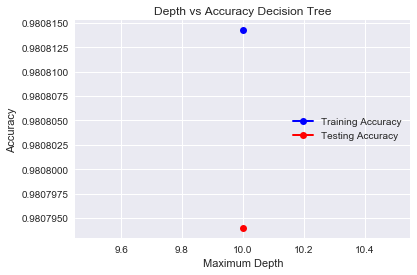

[0.98081424188051969]
[0.98079399272930978]
Wall time: 1min 12s


In [92]:
%%time
# from sklearn import grid_search
'''
###############GridsearchCV#############
param_grid = {'max_depth': np.arange(1,100, 5)
             #'min_samples_leaf':[1**x for x in range(1,10)]
             }
generic_tree =DecisionTreeClassifier()
gridsearch_generic_tree = grid_search.GridSearchCV(estimator=generic_tree, param_grid=param_grid,
                                    n_jobs=-1, scoring='roc_auc');
gridsearch_generic_tree.fit(X=X_train, y=Y_train)
print("The best estimators are: ")
print(gridsearch_generic_tree.best_estimator_)

print(accuracy_score(Y_test, gridsearch_generic_tree.predict(X_test)))
#######################################

'''
# depth_arr = [2,4,6,8,10,12,14,16]
depth_arr = [10]
train_acc = []
test_acc = []

features = [types for types in df.dtypes.index if "Unnamed" not in types]
importances = None
for d in depth_arr:
    #Create
    clf = DecisionTreeClassifier(max_depth=d)
    clf.fit(X_train, Y_train)
    #Find important features
    print(clf.feature_importances_)
    importances = clf.feature_importances_
    # Add to accuracy lists
    train_acc.append(accuracy_score(Y_train, clf.predict(X_train)))
    test_acc.append(accuracy_score(Y_test, clf.predict(X_test)))

importances = clf.feature_importances_
# indices = np.argsort(importances)[::-1]
print("Feature Importances for last run")
for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, indices[f], importances[indices[f]]))
    
plt.figure(1)
plt.plot(depth_arr, train_acc, color='blue', lw=2, marker='o', label="Training Accuracy")
plt.plot(depth_arr, test_acc, color='red', lw=2, marker='o', label="Testing Accuracy")

plt.xlabel("Maximum Depth")
plt.ylabel("Accuracy")
plt.title("Depth vs Accuracy Decision Tree")
plt.legend(loc='center right')
plt.show()

print(train_acc)
print(test_acc)


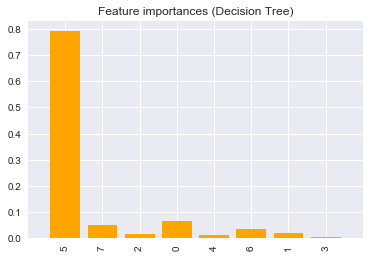

In [94]:
features = [types for types in df.dtypes.index if "Unnamed" not in types]
importances = rforest.feature_importances_


#Attemptin to graph importances.
plt.figure()
plt.title("Feature importances (Decision Tree)")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="orange", align="center")
plt.xticks(range(X_train.shape[1]), indices, rotation='vertical')
plt.xlim([-1, X_train.shape[1]])
plt.show()

## Random Forest Classifier

In [86]:
%%time
############GridsearchCV##########################
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

#Using 10 trees. (Will attempt more in the future after tuning. Gridsearch?)
rforest = RandomForestClassifier(n_estimators=10, random_state=0, n_jobs=-1)

# param_grid = { 
#     'n_estimators': [1,10,200,700],
#     'max_features': ['auto', 'sqrt', 'log2']
# }
# CV_rfc = GridSearchCV(estimator=rforest, param_grid=param_grid, cv= 5)
# CV_rfc.fit(X_train, Y_train)
# print (rforest.best_params_)

rforest.fit(X_train, Y_train)

Wall time: 3min 22s


In [87]:
#Get accruacy.
ypred = rforest.predict(X_test)
print(metrics.classification_report(Y_test, ypred))

             precision    recall  f1-score   support

          0       0.98      1.00      0.99   2164022
          1       0.16      0.00      0.00     42371

avg / total       0.97      0.98      0.97   2206393



1. feature binary_male (0.791899)
2. feature binary_white (0.065764)
3. feature binary_black (0.050891)
4. feature binary_asian (0.036928)
5. feature binary_hispanic (0.020669)
6. feature detail_age (0.017540)
7. feature month_of_death (0.012760)
8. feature education (0.003549)


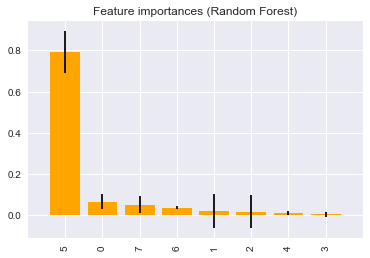

In [95]:
#Checking Feature importances

features = [types for types in df.dtypes.index if "Unnamed" not in types]
importances = rforest.feature_importances_

indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, features[f], importances[indices[f]]))


#Attemptin to graph importances.
plt.figure()
plt.title("Feature importances (Random Forest)")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="orange", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices, rotation='vertical')
plt.xlim([-1, X_train.shape[1]])
plt.show()

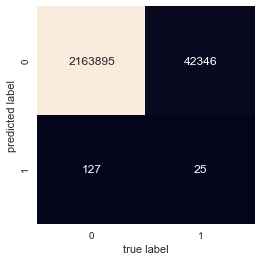

In [89]:
#Attempt at confusion matrix. Need to clean this up a bit.
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()

mat = confusion_matrix(Y_test, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

### ROC (Binary)

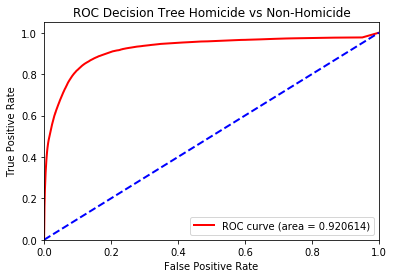

In [22]:
# ROC stuff
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(Y_test, clf.predict_proba(X_test)[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure(2)
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = %f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, color='blue', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Decision Tree Homicide vs Non-Homicide')
plt.legend(loc="lower right")
plt.show()

### ROC (Multiclass)

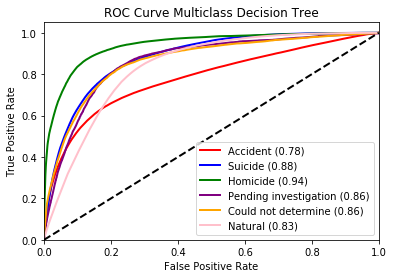

In [19]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
# Example from
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

# Must use 1 vs rest as ROC doesn't do "actual" multiclass
classifier = OneVsRestClassifier(DecisionTreeClassifier(max_depth=10), n_jobs=6)
# Must also binarize y_test for onevsrest
binary_y_test = label_binarize(Y_test, classes=[1, 2, 3, 4, 5, 7])

classifier.fit(X_train, Y_train)
y_score = classifier.predict_proba(X_test)
n_classes = 6

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
# For all classes, calculate and store true, false positive rate, area under curve
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binary_y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = ['red', 'blue', 'green', 'purple', 'orange', 'pink']
labels = ['Accident', 'Suicide', 'Homicide', 'Pending investigation', 'Could not determine', 'Natural']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='{0} ({1:0.2f})'
             ''.format(labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Multiclass Decision Tree')
plt.legend(loc="lower right")
plt.show()

### Linear SVM

In [12]:
svm_fn = 'svm_gridsearch_output.pkl'
##########GridsearchCV######################
# Base svm classifier
base_classifier = SGDClassifier(max_iter=1000, tol=1.0e-12, random_state=123)
# Define alpha as param to search over
svm_alpha_arr = np.asarray([0.0001, 0.001, 0.01, 0.1, 1.0])
params = {'alpha': svm_alpha_arr}
# Fit to training data, 5 fold CV
gs_classifier = GridSearchCV(base_classifier, params, scoring='accuracy', cv=5)
gs_classifier.fit(X_train, Y_train)

print("Best parameter settings:", gs_classifier.best_params_)
print("Validation accuracy: %0.6f" % gs_classifier.best_score_)
print("Test accuracy: %0.6f" % accuracy_score(Y_test, gs_classifier.predict(X_test)))
##########################################
# Save output dict just in case
# https://stackoverflow.com/questions/19201290/how-to-save-a-dictionary-to-a-filew
with open(svm_fn, 'wb') as f:
    pickle.dump(gs_classifier.cv_results_, f)

('Best parameter settings:', {'alpha': 1.0})
Validation accuracy: 0.977827
Test accuracy: 0.979592


In [13]:
# Load data
svm_res = {}
with open(log_reg_fn, 'rb') as f:
    svm = pickle.load(f)
    
plt.figure(1)
plt.plot(svm_alpha_arr, svm_res['mean_train_score'], color='blue', lw=2, marker='o', label="Mean Training Accuracy")
plt.plot(svm_alpha_arr, svm_res['mean_test_score'], color='red', lw=2, marker='o', label="Mean Testing Accuracy")

plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.title("Alpha vs Accuracy Linear Regression")
plt.legend(loc='upper right')
plt.show()

NameError: name 'log_reg_fn' is not defined

## Multiclass Classification on Manner of Death

### Multinomial Logistic Regression

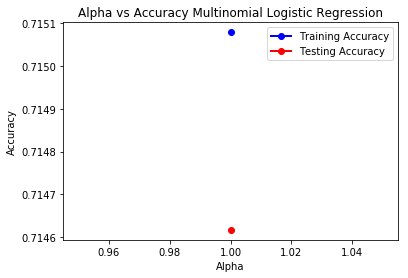

[0.7150782639134419]
[0.7146173113304088]


In [28]:
#c_arr = [0.0001,0.001,0.01,0.1,1.0,10.0,100.0]
'''
c_arr = [1.0]
train_acc = []
test_acc = []
for c in c_arr:    
    classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=123, C=c)
    classifier.fit(X_train, Y_train)
    # Add to accuracy lists
    train_acc.append(accuracy_score(Y_train, classifier.predict(X_train)))
    test_acc.append(accuracy_score(Y_test, classifier.predict(X_test)))
'''
plt.figure(1)
plt.plot(c_arr, train_acc, color='blue', lw=2, marker='o', label="Training Accuracy")
plt.plot(c_arr, test_acc, color='red', lw=2, marker='o', label="Testing Accuracy")

plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.title("Alpha vs Accuracy Multinomial Logistic Regression")
plt.legend(loc='upper right')
plt.show()

print(train_acc)
print(test_acc)

# Unsupervised Analysis

# Cause of Death

## Clustering Causes of Death

In [2]:
import json

with open('./mortality/2015_codes.json') as f:
    d = json.load(f)
#     if(d): 
#         print(d)

## K-Means Clustering

In [5]:
from sklearn.cluster import KMeans
##########GridsearchCV###########
param_grid= {
    'algorithm':[ 'auto', 'full', 'elkan'],
    'max_iter':[300, 400, 500, 600],
    'n_clusters':[x for x in range(1, 10)]
}
generic_kmeans = KMeans()

kmeans_generic_gridsearch = grid_search.GridSearchCV(estimator=generic_kmeans, param_grid=param_grid,
                                    n_jobs=-1, cv= 5)

kmeans_generic_gridsearch.fit(X=X_train, y=Y_train)
print ("The best estimators are: ")
print (kmeans_generic_gridsearch.best_estimator_)
#################################

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "D:\Documents\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-c78385571595>", line 13, in <module>
    kmeans_generic_gridsearch.fit(X=X_train, y=Y_train)
  File "D:\Documents\Anaconda\lib\site-packages\sklearn\grid_search.py", line 838, in fit
    return self._fit(X, y, ParameterGrid(self.param_grid))
  File "D:\Documents\Anaconda\lib\site-packages\sklearn\grid_search.py", line 574, in _fit
    for parameters in parameter_iterable
  File "D:\Documents\Anaconda\lib\site-packages\sklearn\externals\joblib\parallel.py", line 789, in __call__
    self.retrieve()
  File "D:\Documents\Anaconda\lib\site-packages\sklearn\externals\joblib\parallel.py", line 699, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "D:\Documents\Anaconda\lib\multiprocessing\pool.py", line 638, in get
    self.wait(timeout)
  File "D:\Do

KeyboardInterrupt: 

In [6]:
matrix = df.as_matrix()
kmeans = KMeans(n_clusters = 3)
kmeans.fit(matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Text(0.5,1,'Month of Death vs. Age 3-Cluster')

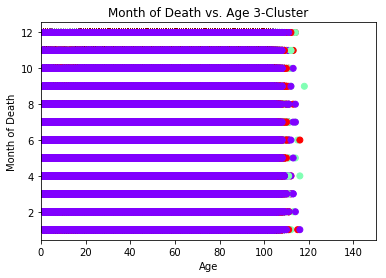

In [8]:
plt.scatter(matrix[:,6], matrix[:,7], c=kmeans.labels_, cmap='rainbow')
plt.xlim(right = 150)
plt.xlim(left = 0)
plt.xlabel('Age')
plt.ylabel('Month of Death')
plt.title('Month of Death vs. Age 3-Cluster')

[[5.000000e+02 0.000000e+00 1.000000e+00 ... 2.000000e+00 0.000000e+00
  7.000000e+00]
 [5.010000e+02 1.000000e+00 0.000000e+00 ... 1.000000e+00 1.000000e+00
  7.000000e+00]
 [5.020000e+02 1.000000e+00 0.000000e+00 ... 1.000000e+00 3.000000e+00
  7.000000e+00]
 ...
 [2.317823e+06 0.000000e+00 1.000000e+00 ... 5.000000e+00 4.000000e+00
  7.000000e+00]
 [2.317824e+06 0.000000e+00 1.000000e+00 ... 4.000000e+00 2.000000e+00
  7.000000e+00]
 [2.317825e+06 0.000000e+00 1.000000e+00 ... 5.000000e+00 3.000000e+00
  7.000000e+00]]


(0, 150)

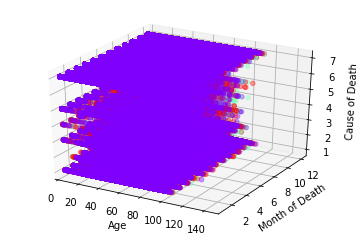

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

print(sample)

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(matrix[:,6], matrix[:,7], matrix[:,9], c = kmeans.labels_, cmap = 'rainbow')

ax.set_xlabel('Age')
ax.set_ylabel('Month of Death')
ax.set_zlabel('Cause of Death')

ax.set_xlim(0, 150)

In [6]:
kcluster = range(1,7)
kmeans_arr = []
kmeans_score = []

for k in kcluster:
    kmeans_arr.append(KMeans(n_clusters = k))
    kmeans_score.append(kmeans_arr[k-1].fit(matrix).score(matrix))

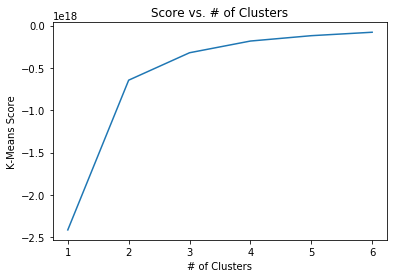

In [7]:
plt.plot(kcluster,kmeans_score)
plt.xlabel('# of Clusters')
plt.ylabel('K-Means Score')
plt.title('Score vs. # of Clusters')
plt.show()

In [10]:
df.corr(method='pearson')**2

,Unnamed: 0,binary_male,binary_white,binary_black,binary_asian,binary_hispanic,detail_age,month_of_death,education,manner_of_death_cleaned
Unnamed: 0,1.000000e+00,0.000307,0.000855,0.000501,0.000380,4.429467e-08,0.000494,0.000092,0.002437,0.002006
binary_male,3.070511e-04,1.000000,0.000081,0.000033,0.000069,8.223487e-04,0.021243,0.000018,0.001831,0.010546
binary_white,8.547552e-04,0.000081,1.000000,0.808623,0.148149,4.644842e-03,0.015901,0.000017,0.002365,0.000303
binary_black,5.010557e-04,0.000033,0.808623,1.000000,0.003323,4.294482e-03,0.013869,0.000009,0.002519,0.000038
binary_asian,3.800037e-04,0.000069,0.148149,0.003323,1.000000,2.983436e-04,0.001545,0.000010,0.000026,0.000717
binary_hispanic,4.429467e-08,0.000822,0.004645,0.004294,0.000298,1.000000e+00,0.005232,0.000035,0.016626,0.003773
detail_age,4.940493e-04,0.021243,0.015901,0.013869,0.001545,5.232443e-03,1.000000,0.000052,0.000043,0.085205
month_of_death,9.249714e-05,0.000018,0.000017,0.000009,0.000010,3.511361e-05,0.000052,1.000000,0.000172,0.000236
education,2.437271e-03,0.001831,0.002365,0.002519,0.000026,1.662608e-02,0.000043,0.000172,1.000000,0.000130
manner_of_death_cleaned,2.006354e-03,0.010546,0.000303,0.000038,0.000717,3.773468e-03,0.085205,0.000236,0.000130,1.000000


Text(0.5,1,'Cause of Death vs. Age 3-Cluster')

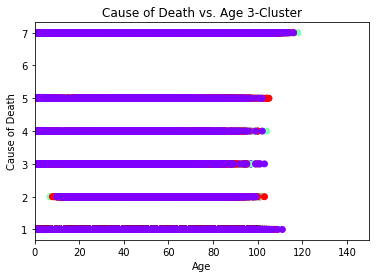

In [17]:
plt.scatter(matrix[:,6], matrix[:,9], c=kmeans.labels_, cmap='rainbow')
plt.xlim(right = 150)
plt.xlim(left = 0)
plt.xlabel('Age')
plt.ylabel('Cause of Death')
plt.title('Cause of Death vs. Age 3-Cluster')